# Abstract
House Price prediction is a very popular dataset for data science competation. In this dataset, 79 explanatory variables describing (almost) every aspect of residential homes in Ames and Iowa. This competition challenges compitator to predict the final price of each home.<br /> 
The solution is divided in many parts.The data engineering and preprocessing is inspired from Ref 4,5,6.The Final model is author's own work. Nothing of the model is taken from any book or blog. Although in order to learn tensorflow implementation the book ref:1 helped me a lot. With out the Knowledge taken from ref:1 and 2 this kernal would not exist.<br /> 
The main feature of this kernal is flexiblity. Almost every thing is tunable without coding.<br /> 
The only thing I belive this kernal should have, is exhaustive search implementation which I would defenitely do after this one.The plain code with less preprocessing achieved only about 0.215 public score at best.<br /> 
The plain solution with out extra data preprocessing and engineering can be found in the given Github link along with other versions of the code. <br />
Github link:https://github.com/IshrakHasin/House-price/tree/master

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


# Understanding the problem label data

Understanding this correlation will help us how we should encode and fillup the respective features.Such as if some feature is very sparse and has weak correlation with sale price we will drop that feature.

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Lets try to understand the correlations with other variables

most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.13

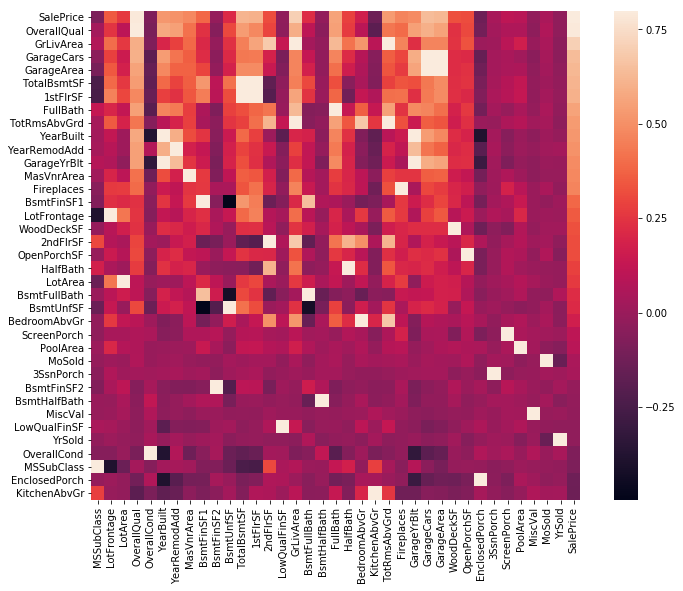

In [5]:
print("most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

# Dataset authur's recommended changes  
The author of the dataset recommends  removing any house more then 4000 sqfeet |

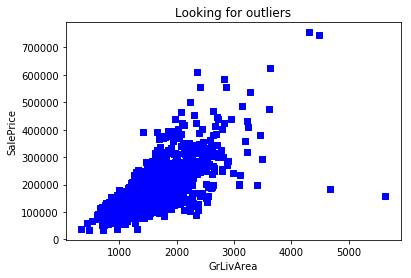

In [6]:
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

The author of the dataset also recommends removing any house  having Garagearea more then 1200  sqfeet. |

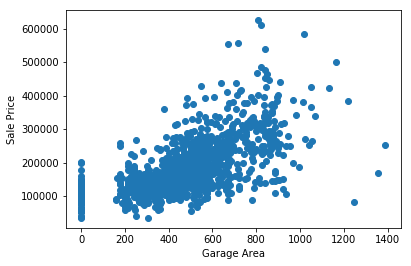

In [7]:
plt.scatter(x=train['GarageArea'], y=train["SalePrice"])
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

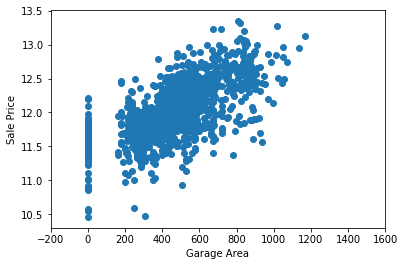

In [8]:
train = train[train['GarageArea'] < 1200]
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

# Data set Concating

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
train["SalePrice_log"] = np.log1p(train["SalePrice"]).astype(np.float64)
train_labels_with_OT=train["SalePrice_log"]
concated_dataset = pd.concat((train, test)).reset_index(drop=True)
concated_dataset.drop(['SalePrice','SalePrice_log'], axis=1, inplace=True)
nconcated=concated_dataset.shape[0]
print("Concated dataset shape",concated_dataset.shape,"train",train.shape,"test",test.shape)


Concated dataset shape (2911, 79) train (1452, 81) test (1459, 79)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


Checking proper spliting

In [10]:
train_post = concated_dataset.iloc[0:1452,:]
test_post = concated_dataset.iloc[1452:2911,:]
print("train shape",train_post.shape)
print("test shape",test_post.shape)

train shape (1452, 79)
test shape (1459, 79)


In [11]:
Test=np.exp(train_labels_with_OT.values)
print(Test)

[208501. 181501. 223501. ... 266501. 142126. 147501.]


# Justifying my reason to take log of saleprice

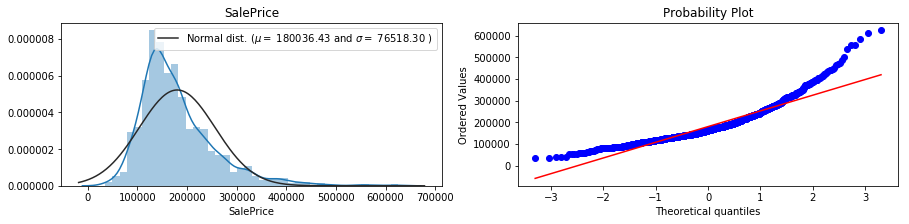

Skewness: 1.571829
Kurtosis: 3.930788


In [12]:
from scipy import stats
from scipy.stats import norm
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('SalePrice')

plt.subplot(122)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

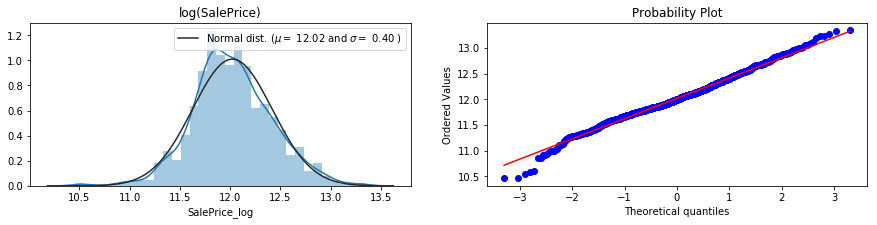

Skewness: 0.065590
Kurtosis: 0.679398


In [13]:
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train_labels_with_OT , fit=norm);

(mu, sigma) = norm.fit(train_labels_with_OT)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('log(SalePrice)')

plt.subplot(122)
res = stats.probplot(train_labels_with_OT, plot=plt)
plt.show()
print("Skewness: %f" % train["SalePrice_log"].skew())
print("Kurtosis: %f" % train["SalePrice_log"].kurt())

# Checking for missing data and handling

In [14]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio
PoolQC,99.725180
MiscFeature,96.427345
Alley,93.198214
Fence,80.419100
FireplaceQu,48.746135
LotFrontage,16.660941
GarageQual,5.462041
GarageCond,5.462041
GarageFinish,5.462041
GarageYrBlt,5.462041


In [15]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    concated_dataset[col] = concated_dataset[col].fillna(0)
concated_dataset.loc[:, "Alley"] = concated_dataset.loc[:, "Alley"].fillna("None")
concated_dataset.loc[:, "BedroomAbvGr"] = concated_dataset.loc[:, "BedroomAbvGr"].fillna(0)
concated_dataset.loc[:, "BsmtQual"] = concated_dataset.loc[:, "BsmtQual"].fillna("No")
concated_dataset.loc[:, "BsmtCond"] = concated_dataset.loc[:, "BsmtCond"].fillna("No")
concated_dataset.loc[:, "BsmtExposure"] = concated_dataset.loc[:, "BsmtExposure"].fillna("No")
concated_dataset.loc[:, "BsmtFinType1"] = concated_dataset.loc[:, "BsmtFinType1"].fillna("No")
concated_dataset.loc[:, "BsmtFinType2"] = concated_dataset.loc[:, "BsmtFinType2"].fillna("No")
concated_dataset.loc[:, "BsmtFullBath"] = concated_dataset.loc[:, "BsmtFullBath"].fillna(0)
concated_dataset.loc[:, "BsmtHalfBath"] = concated_dataset.loc[:, "BsmtHalfBath"].fillna(0)
concated_dataset.loc[:, "BsmtUnfSF"] = concated_dataset.loc[:, "BsmtUnfSF"].fillna(0)
concated_dataset.loc[:, "CentralAir"] = concated_dataset.loc[:, "CentralAir"].fillna("N")
concated_dataset.loc[:, "Condition1"] = concated_dataset.loc[:, "Condition1"].fillna("Norm")
concated_dataset.loc[:, "Condition2"] = concated_dataset.loc[:, "Condition2"].fillna("Norm")
concated_dataset.loc[:, "EnclosedPorch"] = concated_dataset.loc[:, "EnclosedPorch"].fillna(0)
concated_dataset.loc[:, "ExterCond"] = concated_dataset.loc[:, "ExterCond"].fillna("TA")
concated_dataset.loc[:, "ExterQual"] = concated_dataset.loc[:, "ExterQual"].fillna("TA")
concated_dataset.loc[:, "Fence"] = concated_dataset.loc[:, "Fence"].fillna("No")
concated_dataset.loc[:, "FireplaceQu"] = concated_dataset.loc[:, "FireplaceQu"].fillna("No")
concated_dataset.loc[:, "Fireplaces"] = concated_dataset.loc[:, "Fireplaces"].fillna(0)
concated_dataset.loc[:, "Functional"] = concated_dataset.loc[:, "Functional"].fillna("Typ")
concated_dataset.loc[:, "GarageType"] = concated_dataset.loc[:, "GarageType"].fillna("No")
concated_dataset.loc[:, "GarageFinish"] = concated_dataset.loc[:, "GarageFinish"].fillna("No")
concated_dataset.loc[:, "GarageQual"] = concated_dataset.loc[:, "GarageQual"].fillna("No")
concated_dataset.loc[:, "GarageCond"] = concated_dataset.loc[:, "GarageCond"].fillna("No")
concated_dataset.loc[:, "GarageArea"] = concated_dataset.loc[:, "GarageArea"].fillna(0)
concated_dataset.loc[:, "GarageCars"] = concated_dataset.loc[:, "GarageCars"].fillna(0)
concated_dataset.loc[:, "HalfBath"] = concated_dataset.loc[:, "HalfBath"].fillna(0)
concated_dataset.loc[:, "HeatingQC"] = concated_dataset.loc[:, "HeatingQC"].fillna("TA")
concated_dataset.loc[:, "KitchenAbvGr"] = concated_dataset.loc[:, "KitchenAbvGr"].fillna(0)
concated_dataset.loc[:, "KitchenQual"] = concated_dataset.loc[:, "KitchenQual"].fillna("TA")
concated_dataset.loc[:, "LotFrontage"] = concated_dataset.loc[:, "LotFrontage"].fillna(0)
concated_dataset.loc[:, "LotShape"] = concated_dataset.loc[:, "LotShape"].fillna("Reg")
concated_dataset.loc[:, "MasVnrType"] = concated_dataset.loc[:, "MasVnrType"].fillna("None")
concated_dataset.loc[:, "MasVnrArea"] = concated_dataset.loc[:, "MasVnrArea"].fillna(0)
concated_dataset.loc[:, "MiscFeature"] = concated_dataset.loc[:, "MiscFeature"].fillna("No")
concated_dataset.loc[:, "MiscVal"] = concated_dataset.loc[:, "MiscVal"].fillna(0)
concated_dataset.loc[:, "OpenPorchSF"] = concated_dataset.loc[:, "OpenPorchSF"].fillna(0)
concated_dataset.loc[:, "PavedDrive"] = concated_dataset.loc[:, "PavedDrive"].fillna("N")
concated_dataset.loc[:, "PoolQC"] = concated_dataset.loc[:, "PoolQC"].fillna("No")
concated_dataset.loc[:, "PoolArea"] = concated_dataset.loc[:, "PoolArea"].fillna(0)
concated_dataset.loc[:, "SaleCondition"] = concated_dataset.loc[:, "SaleCondition"].fillna("Normal")
concated_dataset.loc[:, "ScreenPorch"] = concated_dataset.loc[:, "ScreenPorch"].fillna(0)
concated_dataset.loc[:, "TotRmsAbvGrd"] = concated_dataset.loc[:, "TotRmsAbvGrd"].fillna(0)
concated_dataset.loc[:, "Utilities"] = concated_dataset.loc[:, "Utilities"].fillna("AllPub")
concated_dataset.loc[:, "WoodDeckSF"] = concated_dataset.loc[:, "WoodDeckSF"].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF'):
    concated_dataset[col] = concated_dataset[col].fillna(0)
concated_dataset['Exterior1st'] = concated_dataset['Exterior1st'].fillna(concated_dataset['Exterior1st'].mode()[0])
concated_dataset['Exterior2nd'] = concated_dataset['Exterior2nd'].fillna(concated_dataset['Exterior2nd'].mode()[0])
concated_dataset['SaleType'] = concated_dataset['SaleType'].fillna(concated_dataset['SaleType'].mode()[0])
concated_dataset['MSZoning'] = concated_dataset['MSZoning'].fillna(concated_dataset['MSZoning'].mode()[0])
concated_dataset['Electrical'] = concated_dataset['Electrical'].fillna(concated_dataset['Electrical'].mode()[0])


Justification for above choices is discussed below.Verify if any data is still missing.

In [16]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio


Nothing  has  null 

# Visualize the distribution
before doing any thing else lets visualize the distribution. This looks good!

In [17]:
import math
color = sns.color_palette()
sns.set_style('darkgrid')

In [18]:
def plot_df_distributions(df, num_cols=3, columns=None):
    if columns is None:
        _columns = df.loc[:,df.dtypes != 'object'].columns.values
    else:
        _columns = columns

    n_cols = num_cols
    n_rows = math.ceil(len(_columns)/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*3.5,n_rows*3))

    for r_idx in range(n_rows):
        for c_idx in range(n_cols):
            col_idx = r_idx*3+c_idx
            
            if col_idx < len(_columns):
                col = _columns[col_idx]
                sns.distplot(df[col], ax=axes[r_idx][c_idx], fit=norm)
    
    plt.tight_layout()
    plt.show()

In [19]:
def plot_df_countplots(df, num_cols=3, columns=None):
    if columns is None:
        _columns = df.loc[:,df.dtypes == 'object'].columns.values
    else:
        _columns = columns

    n_cols = num_cols
    n_rows = math.ceil(len(_columns)/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4,n_rows*3))

    for r_idx in range(n_rows):
        for c_idx in range(n_cols):
            col_idx = r_idx*3+c_idx
            if col_idx < len(_columns):
                col = _columns[col_idx]
                
                sns.countplot(df[col], ax=axes[r_idx][c_idx])
                axes[r_idx][c_idx].set_title(col)
                for item in axes[r_idx][c_idx].get_xticklabels():
                    item.set_rotation(45)
    
    plt.tight_layout()
    plt.show()

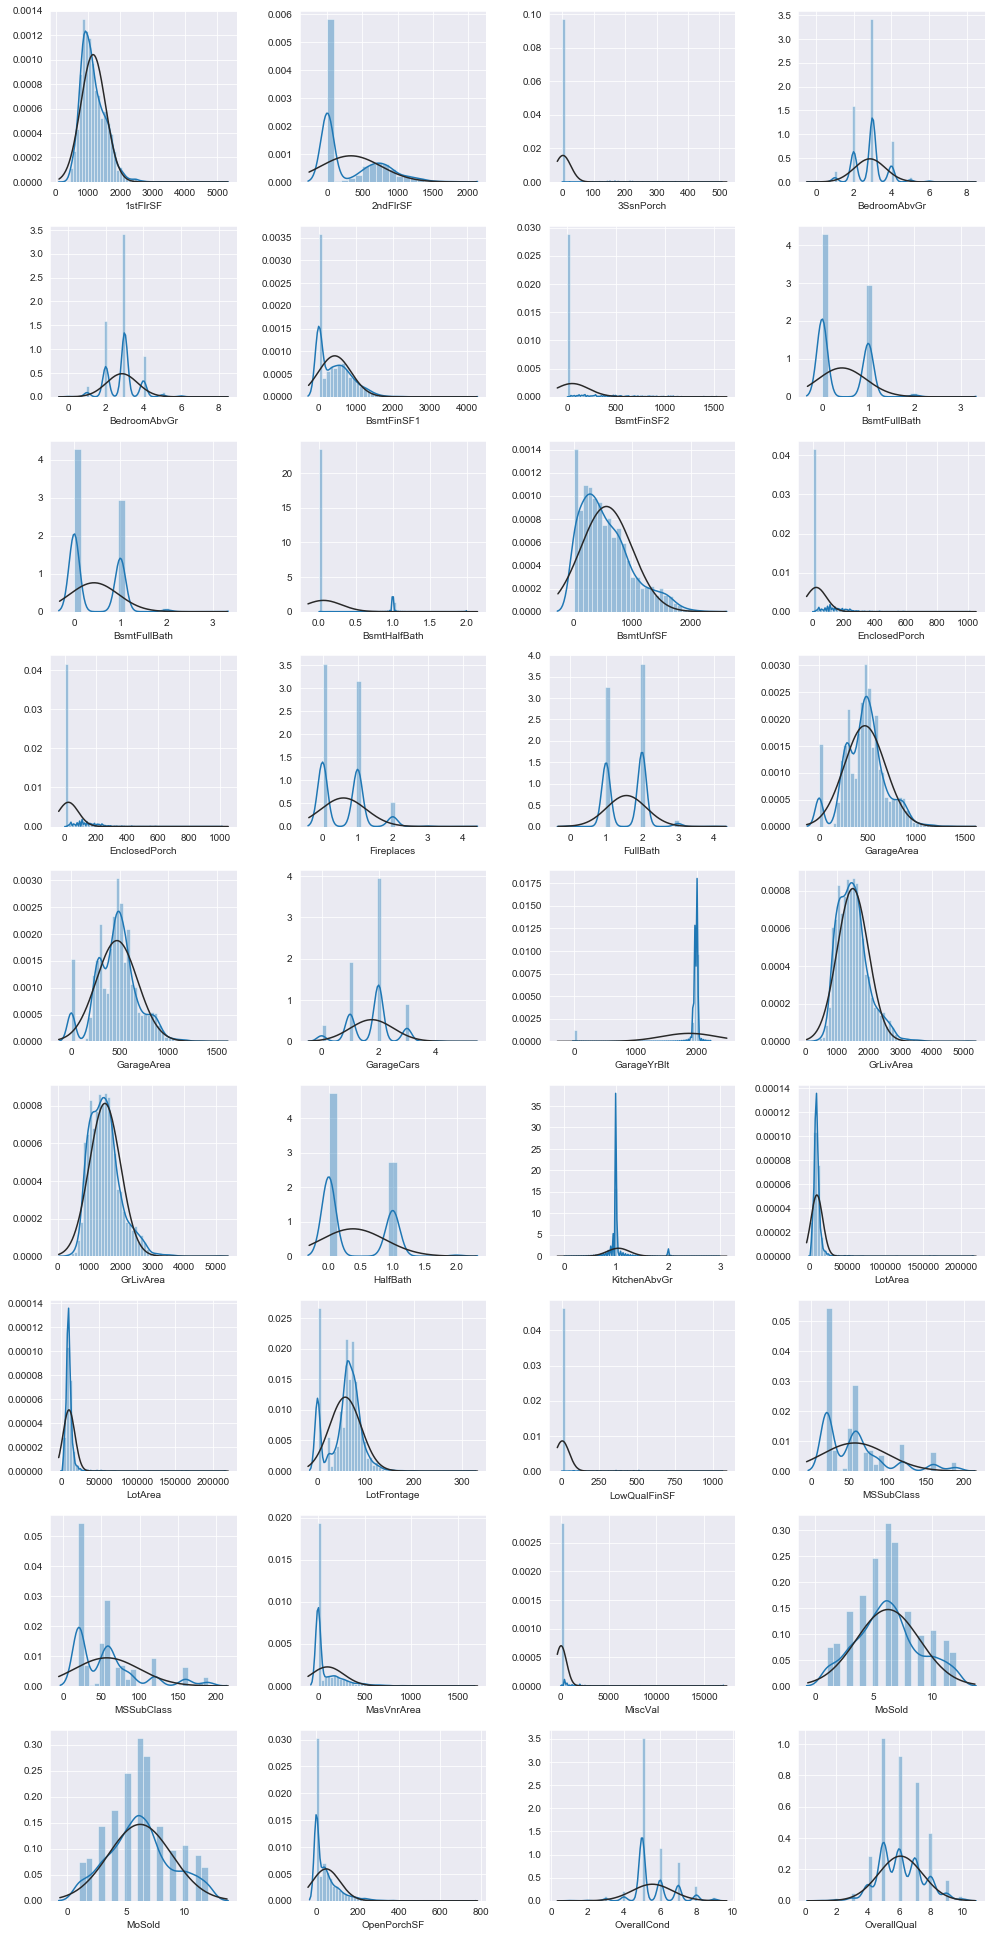

None

In [20]:
display(plot_df_distributions(concated_dataset, num_cols=4))


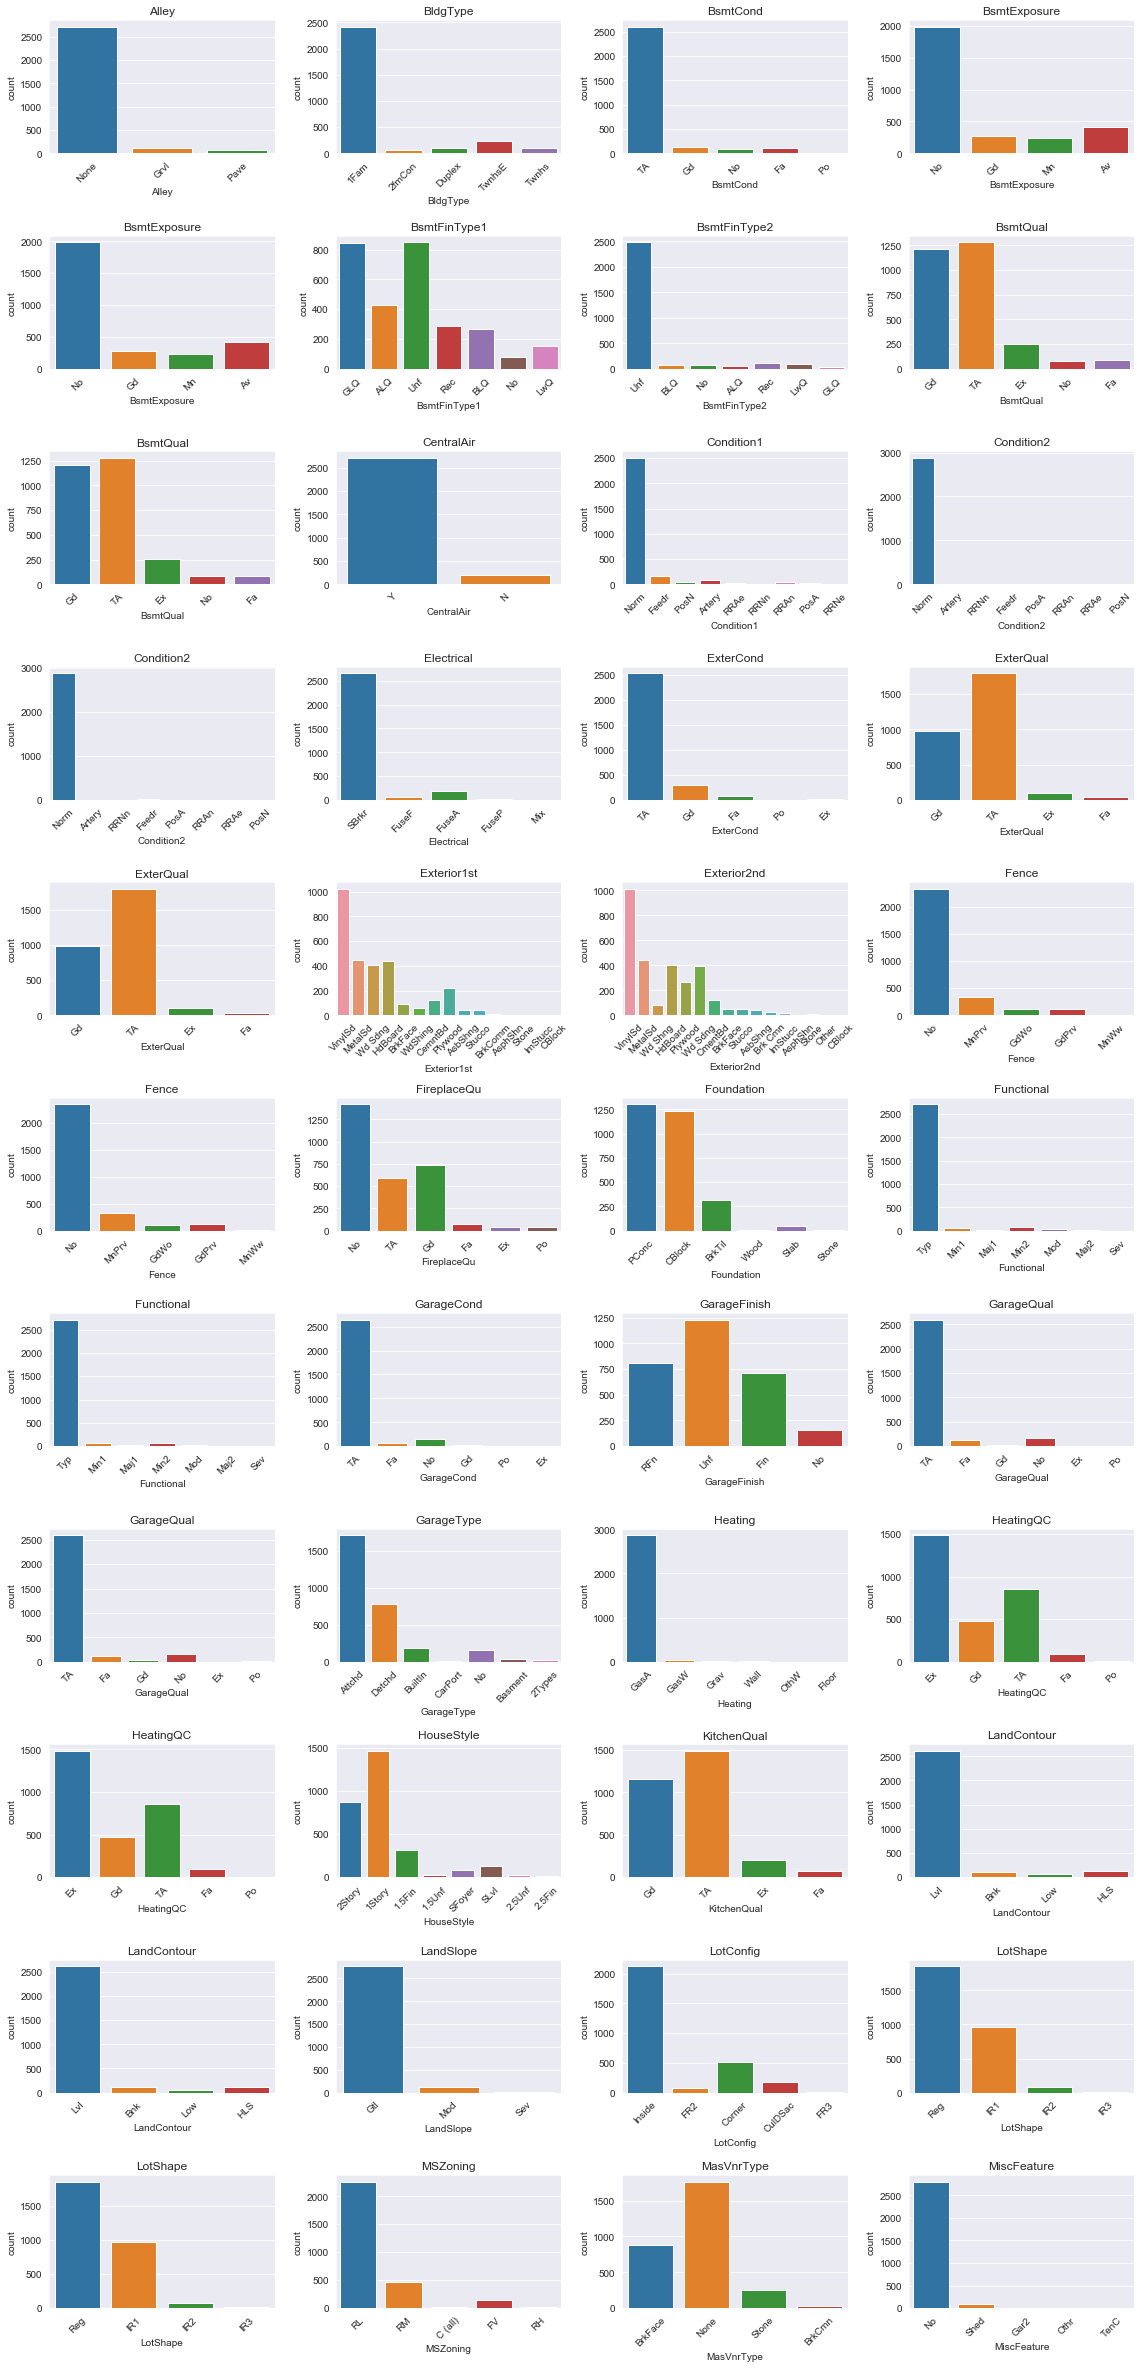

In [21]:
plot_df_countplots(concated_dataset, num_cols=4)


# Black List of feature
Some features are not balanced and badly effect the model. But we can't be sure about that right now.So let's make them black listed.If model is doing well without them we will simly drop them.

In [20]:
black_list=[]
black_list.append('Street')
black_list.append('Condition2')
black_list.append('RoofMatl')
black_list.append('Heating')
black_list.append('MiscVal')
black_list.append('Utilities')


# Add Features 
Lets add some new features. Those features are made out of prior experice on sloving that same problem.We have seen that simple applying One hot encoding and label encoding made our models performace stuck (public score=.24). So this time we will add some new features.


In [21]:
concated_dataset['TotalSF'] = concated_dataset['TotalBsmtSF'] + concated_dataset['1stFlrSF'] + concated_dataset['2ndFlrSF']


# Feature Encoding
For training through neural network our features must the in some numerical value. Since gradiantent decent algorithm (such as back propagation ) uses derivative to get optimised value of wights.Lets catagorize the the catgorical feature! 

In [22]:
# Some numerical features are actually really categories
concated_dataset = concated_dataset.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [23]:
# Encode some categorical features as ordered numbers when there is information in the order
concated_dataset = concated_dataset.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [24]:
concated_dataset = concated_dataset.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

# 1.Feature  Engineering
Adding new featues showed some great improvement in accuracy

# 1.0 Simplified Feature
We will add some simplified version of existing feature

In [25]:
concated_dataset["SimplOverallQual"] = concated_dataset.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
concated_dataset["SimplOverallCond"] = concated_dataset.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
concated_dataset["SimplPoolQC"] = concated_dataset.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
concated_dataset["SimplGarageCond"] = concated_dataset.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
concated_dataset["SimplGarageQual"] = concated_dataset.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
concated_dataset["SimplFireplaceQu"] = concated_dataset.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
concated_dataset["SimplFireplaceQu"] = concated_dataset.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
concated_dataset["SimplFunctional"] = concated_dataset.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
concated_dataset["SimplKitchenQual"] = concated_dataset.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
concated_dataset["SimplHeatingQC"] = concated_dataset.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
concated_dataset["SimplBsmtFinType1"] = concated_dataset.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
concated_dataset["SimplBsmtFinType2"] = concated_dataset.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
concated_dataset["SimplBsmtCond"] = concated_dataset.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
concated_dataset["SimplBsmtQual"] = concated_dataset.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
concated_dataset["SimplExterCond"] = concated_dataset.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
concated_dataset["SimplExterQual"] = concated_dataset.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })


# 1.1 Combine Existing Feature
We will create and append some new feature. Those are creating from the existaing feature.

In [26]:
concated_dataset["OverallGrade"] = concated_dataset["OverallQual"] * concated_dataset["OverallCond"]
# Overall quality of the garage
concated_dataset["GarageGrade"] = concated_dataset["GarageQual"] * concated_dataset["GarageCond"]
# Overall quality of the exterior
concated_dataset["ExterGrade"] = concated_dataset["ExterQual"] * concated_dataset["ExterCond"]
# Overall kitchen score
concated_dataset["KitchenScore"] = concated_dataset["KitchenAbvGr"] * concated_dataset["KitchenQual"]
# Overall fireplace score
concated_dataset["FireplaceScore"] = concated_dataset["Fireplaces"] * concated_dataset["FireplaceQu"]
# Overall garage score
concated_dataset["GarageScore"] = concated_dataset["GarageArea"] * concated_dataset["GarageQual"]
# Overall pool score
concated_dataset["PoolScore"] = concated_dataset["PoolArea"] * concated_dataset["PoolQC"]
# Simplified overall quality of the house
concated_dataset["SimplOverallGrade"] = concated_dataset["SimplOverallQual"] * concated_dataset["SimplOverallCond"]
# Simplified overall quality of the exterior
concated_dataset["SimplExterGrade"] = concated_dataset["SimplExterQual"] * concated_dataset["SimplExterCond"]
# Simplified overall pool score
concated_dataset["SimplPoolScore"] = concated_dataset["PoolArea"] * concated_dataset["SimplPoolQC"]
# Simplified overall garage score
concated_dataset["SimplGarageScore"] = concated_dataset["GarageArea"] * concated_dataset["SimplGarageQual"]
# Simplified overall fireplace score
concated_dataset["SimplFireplaceScore"] = concated_dataset["Fireplaces"] * concated_dataset["SimplFireplaceQu"]
# Simplified overall kitchen score
concated_dataset["SimplKitchenScore"] = concated_dataset["KitchenAbvGr"] * concated_dataset["SimplKitchenQual"]
# Total number of bathrooms
concated_dataset["TotalBath"] = concated_dataset["BsmtFullBath"] + (0.5 * concated_dataset["BsmtHalfBath"]) + \
concated_dataset["FullBath"] + (0.5 * concated_dataset["HalfBath"])
# Total SF for house (incl. basement)
concated_dataset["AllSF"] = concated_dataset["GrLivArea"] + concated_dataset["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
concated_dataset["AllFlrsSF"] = concated_dataset["1stFlrSF"] + concated_dataset["2ndFlrSF"]
# Total SF for porch
concated_dataset["AllPorchSF"] = concated_dataset["OpenPorchSF"] + concated_dataset["EnclosedPorch"] + \
concated_dataset["3SsnPorch"] + concated_dataset["ScreenPorch"]
# Has masonry veneer or not
concated_dataset["HasMasVnr"] = concated_dataset.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
concated_dataset["BoughtOffPlan"] = concated_dataset.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

# 1.2 Double simpling
Now we will find the features which has most impact on target

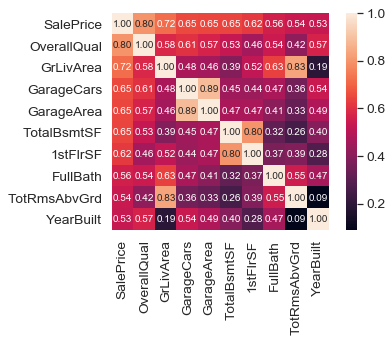

In [27]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [28]:
concated_dataset["OverallQual-s2"] = concated_dataset["OverallQual"] ** 2
concated_dataset["OverallQual-s3"] = concated_dataset["OverallQual"] ** 3
concated_dataset["OverallQual-Sq"] = np.sqrt(concated_dataset["OverallQual"])
concated_dataset["AllSF-2"] = concated_dataset["AllSF"] ** 2
concated_dataset["AllSF-3"] = concated_dataset["AllSF"] ** 3
concated_dataset["AllSF-Sq"] = np.sqrt(concated_dataset["AllSF"])
concated_dataset["AllFlrsSF-2"] = concated_dataset["AllFlrsSF"] ** 2
concated_dataset["AllFlrsSF-3"] = concated_dataset["AllFlrsSF"] ** 3
concated_dataset["AllFlrsSF-Sq"] = np.sqrt(concated_dataset["AllFlrsSF"])
concated_dataset["GrLivArea-2"] = concated_dataset["GrLivArea"] ** 2
concated_dataset["GrLivArea-3"] = concated_dataset["GrLivArea"] ** 3
concated_dataset["GrLivArea-Sq"] = np.sqrt(concated_dataset["GrLivArea"])
concated_dataset["SimplOverallQual-s2"] = concated_dataset["SimplOverallQual"] ** 2
concated_dataset["SimplOverallQual-s3"] = concated_dataset["SimplOverallQual"] ** 3
concated_dataset["SimplOverallQual-Sq"] = np.sqrt(concated_dataset["SimplOverallQual"])
concated_dataset["ExterQual-2"] = concated_dataset["ExterQual"] ** 2
concated_dataset["ExterQual-3"] = concated_dataset["ExterQual"] ** 3
concated_dataset["ExterQual-Sq"] = np.sqrt(concated_dataset["ExterQual"])
concated_dataset["GarageCars-2"] = concated_dataset["GarageCars"] ** 2
concated_dataset["GarageCars-3"] = concated_dataset["GarageCars"] ** 3
concated_dataset["GarageCars-Sq"] = np.sqrt(concated_dataset["GarageCars"])
concated_dataset["TotalBath-2"] = concated_dataset["TotalBath"] ** 2
concated_dataset["TotalBath-3"] = concated_dataset["TotalBath"] ** 3
concated_dataset["TotalBath-Sq"] = np.sqrt(concated_dataset["TotalBath"])
concated_dataset["KitchenQual-2"] = concated_dataset["KitchenQual"] ** 2
concated_dataset["KitchenQual-3"] = concated_dataset["KitchenQual"] ** 3
concated_dataset["KitchenQual-Sq"] = np.sqrt(concated_dataset["KitchenQual"])
concated_dataset["GarageScore-2"] = concated_dataset["GarageScore"] ** 2
concated_dataset["GarageScore-3"] = concated_dataset["GarageScore"] ** 3
concated_dataset["GarageScore-Sq"] = np.sqrt(concated_dataset["GarageScore"])

# Feature type Analysis

In [29]:
categorical_features = concated_dataset.select_dtypes(include = ["object"]).columns
numerical_features = concated_dataset.select_dtypes(exclude = ["object"]).columns
print(categorical_features)
print(numerical_features)
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
Numerical_feature=numerical_features.values
print(Numerical_feature)

Index(['Alley', 'BldgType', 'BsmtCond', 'CentralAir', 'Condition1',
       'Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence',
       'Foundation', 'GarageFinish', 'GarageType', 'Heating', 'HouseStyle',
       'LandContour', 'LotConfig', 'MSSubClass', 'MSZoning', 'MasVnrType',
       'MiscFeature', 'MoSold', 'Neighborhood', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType'],
      dtype='object')
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtFullBath',
       ...
       'GarageCars-Sq', 'TotalBath-2', 'TotalBath-3', 'TotalBath-Sq',
       'KitchenQual-2', 'KitchenQual-3', 'KitchenQual-Sq', 'GarageScore-2',
       'GarageScore-3', 'GarageScore-Sq'],
      dtype='object', length=117)
Numerical features : 117
Categorical features : 27
['1stFlrSF' '2ndFlrSF' '3SsnPorch' 'BedroomAbvGr' 'BsmtExposure'
 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtFinType1' 'BsmtFinType2' 'B

In [30]:
concated_dataset_num = concated_dataset[numerical_features]
concated_dataset_cat = concated_dataset[categorical_features]


We created some new features. Those might be sparse. So filling those up. 

In [31]:
print("NAs for numerical features in train : " + str(concated_dataset_num.isnull().values.sum()))
concated_dataset_num = concated_dataset_num.fillna(concated_dataset_num.median())
print("Remaining NAs for numerical features in train : " + str(concated_dataset_num.isnull().values.sum()))

NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0


In [32]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio


# Explaination for above choices
choices for fiiling missing data and replacement. This part is for illustration and explaination.So code are commented as they are coded previously .

From the list we can begin working with data filling.First let check what is PoolQC and why this is empthy.This have four values Ex=Excellent,Gd=Good,TA=typical,Fa=Fair,NA=no pool.So may be missing data should be NA.Lets also help our model by just replacing with neumerical values I will give Ex=4 and No Pool=0. Since the saleprice should be higher if the PoolQC is more.

Now this looks good. Now we can investigate next feature. Which MiscFeature is 96% missing data.This has Elev {Elevator}, Gar2 {2nd Garage} ,Othr {Other},Shed {Shed (over 100 SF}TenC {Tennis Court},NA   {None} values.But we can but keep NA lets replace. We also need to make it catagorical at some point.This feature is also black listed.

Now lets fill up Alley.This can be of 3 types Gravel, paved and No Alley which means NA will have different meaning.We will one hot encode that.

Lets encode time like feature.Well we should one hot encode those but lets's see how it helps if we let it behave like neumerical feature 

Now lets find out how to encode fireplace. From the descreption Ex Excellent - Exceptional Masonry Fireplace Gd Good - Masonry Fireplace in main level TA Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement Fa Fair - Prefabricated Fireplace in basement Po Poor - Ben Franklin Stove NA No Fireplace So we can replace Ex with 5 and NA with 0.

LotFrontage: Linear feet of street connected to property.NA probably means not given. LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

GarageType, GarageFinish, GarageQual, GarageCond is NA if no Garage is there. NA should be replaced with None.I will fill up maually.

Lets's keep a list of things we can't decide where it is ranked or not.


In [33]:
Undecided_ranked=[]
Undecided_unranked=[]
Undecided_unranked.append("Functional")
Undecided_unranked.append("Alley")
Undecided_unranked.append("BsmtFin1")
Undecided_unranked.append("Bsmtfin2")
Undecided_ranked.append("Fence")

In [34]:
Undecided_ranked.append("PavedDrive")

LotShape: General shape of property
       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
Does general shape better then Irregular.Not always may be fency Irregular shape is more costly.For now manulay encode that but adding to undeceded list for future experiment.

In [35]:
Undecided_ranked.append("LandSlope")
Undecided_ranked.append("LotShape")

Adding simplified version of existing feature.

Let's take unorder catagorical data to str. So that we can use pd dummy to one hot encode. 

# Searching skewness
Neural network works best when it distribution is taken from normal distribution. Skewness is asymmetry in a statistical distribution, in which the curve appears distorted or skewed either to the left or to the right. Skewness can be quantified to define the extent to which a distribution differs from a normal distribution.

In [36]:
from scipy.stats import skew
feature_skewness = concated_dataset[Numerical_feature].apply(lambda x: skew(x.dropna()))
feature_skewness = feature_skewness.sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' : feature_skewness})
skewness.head(10)

,Skew
PoolScore,24.500731
SimplPoolScore,24.410348
MiscVal,21.926841
PoolQC,21.891199
SimplPoolQC,20.274742
PoolArea,18.688884
AllSF-3,17.917674
LotArea,13.176757
LowQualFinSF,12.071863
3SsnPorch,11.360117


In [37]:
high_skewed_features = skewness.loc[abs(skewness.Skew) >= 0.5].index.values


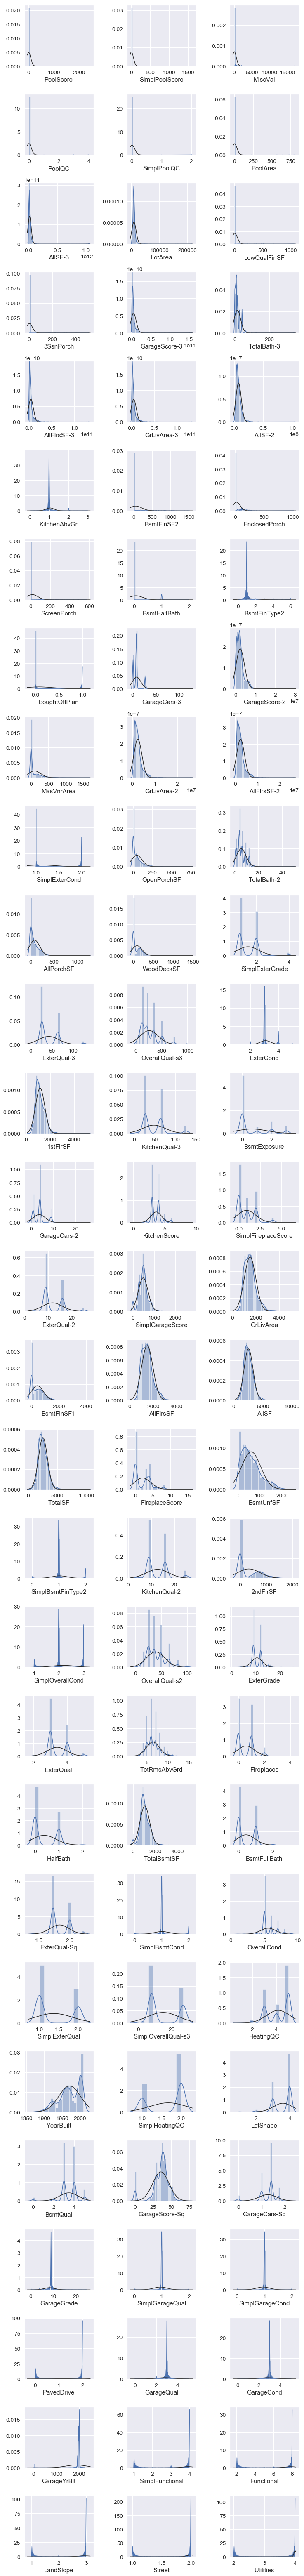

In [38]:
plot_df_distributions(concated_dataset, columns=high_skewed_features)

# Fixing skewness with Boxcox transformation
A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn't normal, applying a Box-Cox means that you are able to run a test which works well in normal distribution. Such as Neural netork regressors.

In [39]:
from scipy.special import boxcox1p

lam = 0.15
for feat in high_skewed_features:
    concated_dataset[feat] = boxcox1p(concated_dataset[feat], lam)
    


In [40]:
concated_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,11.692623,11.686189,0.0,None,3,1Fam,3,0.000000,11.170327,0.0,...,0.942290,3.156265,5.088839,1.870829,3.530419,5.802739,2.000000,54.805612,179.999048,4.993065
1,12.792276,0.000000,0.0,None,3,1Fam,3,1.540963,12.062832,0.0,...,0.942290,2.306783,3.496358,1.581139,2.750250,4.322948,1.732051,51.660718,165.859245,4.844785
2,11.892039,11.724598,0.0,None,3,1Fam,3,0.730463,10.200343,0.0,...,0.942290,3.156265,5.088839,1.870829,3.530419,5.802739,2.000000,56.751869,188.933813,5.082129
3,12.013683,11.354094,0.0,None,3,1Fam,4,0.000000,8.274266,0.0,...,1.084767,1.820334,2.602594,1.414214,3.530419,5.802739,2.000000,57.795611,193.782414,5.129087
4,12.510588,12.271365,0.0,None,4,1Fam,3,1.194318,10.971129,0.0,...,1.084767,3.156265,5.088839,1.870829,3.530419,5.802739,2.000000,63.109485,219.072091,5.360028


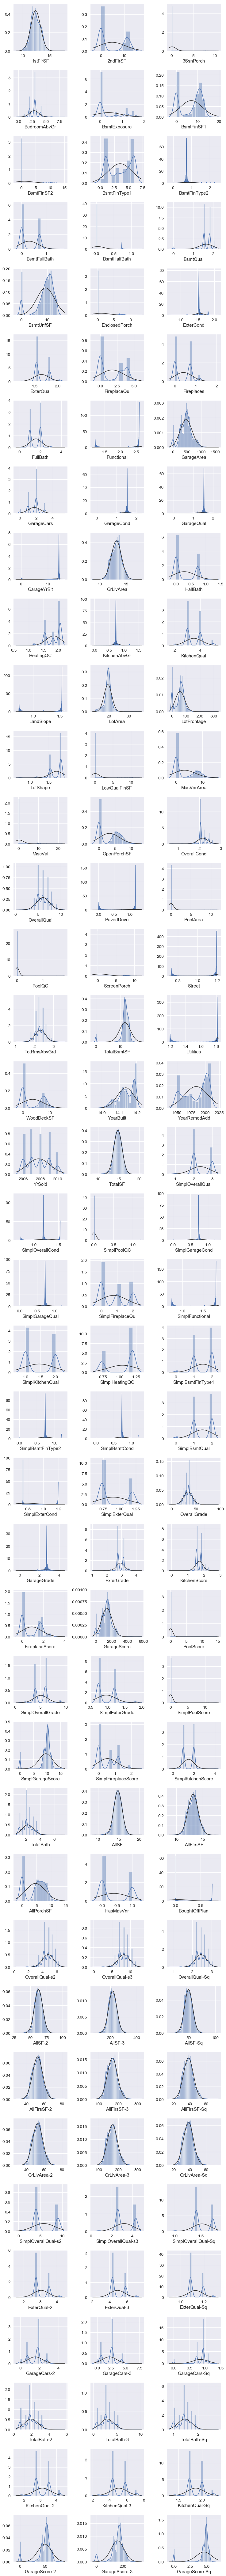

In [41]:
plot_df_distributions(concated_dataset, columns=Numerical_feature)

Either or both of teh scaller is used. Keeping both so that I can experiment later.

# Standard Scaling
The StandardScaler assumes your data is normally distributed within each feature and will scale them such that the distribution is now centred around 0, with a standard deviation of 1.

The mean and standard deviation are calculated for the feature and then the feature is scaled based on:
$\frac{x_i-mean(x)}{stdv(x)}$

In [42]:
from sklearn.preprocessing import StandardScaler
Std_nummerical = StandardScaler()
Std_nummerical.fit(concated_dataset[Numerical_feature])
concated_dataset[Numerical_feature] = Std_nummerical.transform(concated_dataset[Numerical_feature])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [43]:
type(concated_dataset)

pandas.core.frame.DataFrame

In [44]:
concated_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,-0.785209,1.215787,-0.112469,None,0.170340,1Fam,3,-0.652944,0.803472,-0.358575,...,0.374960,1.525033,1.552536,1.486001,0.778934,0.774619,0.773356,0.414248,0.428145,0.358802
1,0.413604,-0.860017,-0.112469,None,0.170340,1Fam,3,2.031925,0.977848,-0.358575,...,0.374960,0.420710,0.407097,0.430591,-0.760142,-0.762110,-0.759444,0.184613,0.139553,0.230057
2,-0.567811,1.222609,-0.112469,None,0.170340,1Fam,3,0.619766,0.613958,-0.358575,...,0.374960,1.525033,1.552536,1.486001,0.778934,0.774619,0.773356,0.556360,0.610502,0.436133
3,-0.435198,1.156797,-0.112469,None,0.170340,1Fam,4,-0.652944,0.237644,-0.358575,...,0.980773,-0.211672,-0.235769,-0.177557,0.778934,0.774619,0.773356,0.632572,0.709461,0.476905
4,0.106515,1.319731,-0.112469,None,1.385681,1Fam,3,1.427954,0.764553,-0.358575,...,0.980773,1.525033,1.552536,1.486001,0.778934,0.774619,0.773356,1.020581,1.225620,0.677422


# Minmax Scaling
Minmax normalization is a normalization strategy which linearly transforms x to y= (x-min)/(max-min), where min and max are the minimum and maximum values in X, where X is the set of observed values of x. 

# Preparing for One Hot encoding
In order to make unordered catagories represented in one hot encoding with pandas dummies we have to make the feature object type first. This one is for flexiblity optional usage.

# Removing Black listed features
This is experimental if it this does not help the model. We will undo that.

In [45]:
concated_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,-0.785209,1.215787,-0.112469,None,0.170340,1Fam,3,-0.652944,0.803472,-0.358575,...,0.374960,1.525033,1.552536,1.486001,0.778934,0.774619,0.773356,0.414248,0.428145,0.358802
1,0.413604,-0.860017,-0.112469,None,0.170340,1Fam,3,2.031925,0.977848,-0.358575,...,0.374960,0.420710,0.407097,0.430591,-0.760142,-0.762110,-0.759444,0.184613,0.139553,0.230057
2,-0.567811,1.222609,-0.112469,None,0.170340,1Fam,3,0.619766,0.613958,-0.358575,...,0.374960,1.525033,1.552536,1.486001,0.778934,0.774619,0.773356,0.556360,0.610502,0.436133
3,-0.435198,1.156797,-0.112469,None,0.170340,1Fam,4,-0.652944,0.237644,-0.358575,...,0.980773,-0.211672,-0.235769,-0.177557,0.778934,0.774619,0.773356,0.632572,0.709461,0.476905
4,0.106515,1.319731,-0.112469,None,1.385681,1Fam,3,1.427954,0.764553,-0.358575,...,0.980773,1.525033,1.552536,1.486001,0.778934,0.774619,0.773356,1.020581,1.225620,0.677422


# One hot encoding
by Pandas dummy variable

In [46]:

concated_dataset_D = pd.get_dummies(concated_dataset)


In [47]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(concated_dataset_D)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,EnclosedPorch,ExterCond,ExterQual,FireplaceQu,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotFrontage,LotShape,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF,SimplOverallQual,SimplOverallCond,SimplPoolQC,SimplGarageCond,SimplGarageQual,SimplFireplaceQu,SimplFunctional,SimplKitchenQual,SimplHeatingQC,SimplBsmtFinType1,SimplBsmtFinType2,SimplBsmtCond,SimplBsmtQual,SimplExterCond,SimplExterQual,OverallGrade,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,SimplOverallGrade,SimplExterGrade,SimplPoolScore,SimplGarageScore,SimplFireplaceScore,SimplKitchenScore,TotalBath,AllSF,AllFlrsSF,AllPorchSF,HasMasVnr,BoughtOffPlan,OverallQual-s2,OverallQual-s3,OverallQual-Sq,AllSF-2,AllSF-3,AllSF-Sq,AllFlrsSF-2,AllFlrsSF-3,AllFlrsSF-Sq,GrLivArea-2,GrLivArea-3,GrLivArea-Sq,SimplOverallQual-s2,SimplOverallQual-s3,SimplOverallQual-Sq,ExterQual-2,ExterQual-3,ExterQual-Sq,GarageCars-2,GarageCars-3,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq,Alley_1,Alley_2,Alley_None,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,CentralAir_N,CentralAir_Y,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageFinish_Fin,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,MSSubClass_SC120,MSSubClass_SC150,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,MSSubClass_SC75,MSSubClass_SC80,MSSubClass_SC85,MSSubClass_SC90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_Gar2,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Apr,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_

In [48]:
concated_dataset_D.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [49]:
concated_dataset_D['2ndFlrSF']

0       1.215787
1      -0.860017
2       1.222609
3       1.156797
4       1.319731
5       1.020997
6      -0.860017
7       1.285233
8       1.154254
9      -0.860017
10     -0.860017
11      1.360885
12     -0.860017
13     -0.860017
14     -0.860017
15     -0.860017
16     -0.860017
17     -0.860017
18     -0.860017
19     -0.860017
20      1.393924
21     -0.860017
22     -0.860017
23     -0.860017
24     -0.860017
25     -0.860017
26     -0.860017
27     -0.860017
28     -0.860017
29     -0.860017
          ...   
2881   -0.860017
2882    1.100117
2883   -0.860017
2884    0.790880
2885    0.820287
2886   -0.860017
2887   -0.860017
2888   -0.860017
2889   -0.860017
2890   -0.860017
2891   -0.860017
2892   -0.860017
2893   -0.860017
2894   -0.860017
2895   -0.860017
2896   -0.860017
2897   -0.860017
2898    1.111922
2899   -0.860017
2900   -0.860017
2901   -0.860017
2902    1.004530
2903   -0.860017
2904    1.004530
2905    1.004530
2906    1.004530
2907    1.004530
2908   -0.8600

# Splitting Data back to Train and Test set

In [50]:
train_postprocess = concated_dataset_D.iloc[0:1452,:]
test_postprocess = concated_dataset_D.iloc[1452:2911,:]
print("train shape",train_postprocess.shape)
print("test shape",test_postprocess.shape)

train shape (1452, 325)
test shape (1459, 325)


# Removing Out layers
We will use simple isolation Forest to remove outlayers.In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using  random partitioning like in isolation tree or any decession tree, they should be identified closer to the root of the tree (shorter average path length) with fewer splits necessary.

In [51]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(max_samples=100, random_state=42)
isolation_forest.fit(train_postprocess)

outlier_info = pd.DataFrame(isolation_forest.predict(train_postprocess), columns=['Top'])

no_outlier_idxs = outlier_info[outlier_info['Top'] == 1].index.values
outlier_idxs = outlier_info[outlier_info['Top'] == -1].index.values
train_postprocess_without_OT = train_postprocess.iloc[no_outlier_idxs]

train_labels_without_OT = train_labels_with_OT.iloc[no_outlier_idxs]

print('Number of outliers: {}'.format(outlier_idxs.shape[0]))
print('Shape train dataset after removal: {}'.format(train_postprocess_without_OT.shape[0]))
print('Shape train dataset labes after removal: {}'.format(train_labels_without_OT.shape[0]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Number of outliers: 146
Shape train dataset after removal: 1306
Shape train dataset labes after removal: 1306


# Combining again for PCA

In [52]:
ntrainp = train_postprocess_without_OT.shape[0]
ntestp = test_postprocess.shape[0]
concated_dataset_DR = pd.concat((train_postprocess_without_OT, test_postprocess)).reset_index(drop=True)
concated_dataset_DR.shape

(2765, 325)

# Dimenstinality Reduction
Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution, as we will see. This problem is often referred to as the curse of dimensionality. Reducing dimensionality does lose some information (just like compressing an image to JPEG can degrade its quality), so even though it will speed up training, it may also make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain. So you should first try to train your system with the original data before considering using dimensionality reduction if training is too slow. In some cases, however, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher performance (but in general it won’t; it will just speed up training).


# Principle Component Analysis
Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it. 

# Manifold Learning 
Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called Manifold Learning. It relies on the manifold assumption, also called the manifold hypothesis, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed
<br />
The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.However, this assumption does not always hold. <br />
if you reduce the dimensionality of your training set before training a model, it will definitely speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset. 

# Locally Linear Embedding (LLE)
Locally Linear Embedding (LLE)is another very powerful nonlinear dimensionality reduction (NLDR) technique. It is a Manifold Learning technique that does not rely on projections like the previous algorithms. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly). This makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise

In [53]:
train_postprocess = concated_dataset_DR[0:1306]
test_postprocess = concated_dataset_DR[1306:2769]

# 0. Processing data for feeding NN
Usually float32 formated data is feed to neural network so that it can calculate small numbers without any round off or truncation error.  

In [54]:
x_train = train_postprocess.astype(np.float64)
x_train.shape

(1306, 325)

In [55]:
y_train = train_labels_without_OT.values
y_train.shape

(1306,)

In [56]:
Test=np.expm1(y_train)
print(Test)

[208500. 181500. 223500. ... 210000. 142125. 147500.]


In [57]:
x_test = test_postprocess.astype(np.float64)
x_test.shape


(1459, 325)

# 1.1 Splitting Training set to valid-train set 
To understand how our model is doing we must have some validation set. We will check performance on every 100 epoch on validation set. We have also implemented early stoping.Uff!! We took 25% validation set.

In [58]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(x_train, y_train, test_size=0.2, random_state=200)

1.2 keeping some important shapes in variables for ease of use

In [59]:
m_train,n_train=X_train_val.shape
m_val,n_val=X_test_val.shape
m_test,n_test=x_test.shape

# Importing Libraries 
We imported data time to save check points

In [60]:
import tensorflow as tf
from datetime import datetime


# Final Model

We added the bias to the input 

In [61]:
#scalling and adding bias

scaled_x_train_plus_bias = np.c_[np.ones((m_train, 1)),X_train_val]
scaled_x_val_plus_bias = np.c_[np.ones((m_val, 1)),X_test_val]
scaled_x_test_plus_bias = np.c_[np.ones((m_test, 1)),x_test]


In [62]:
# hidden layers neuron numbers, batchsize and epoch number
tf.reset_default_graph()

n_inputs = n_train
n_hidden1 = 32
n_hidden2 = 16
n_hidden3=8
n_hidden4=4
n_hidden5=2
n_hidden6=0
n_outputs = 1
n_epochs = 5000 
batch_size = 32


 # Learning rate scheduling (Exponential scheduling) 
Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge . If we set it too low, training will eventually converge to the optimum, but it will take a very long time. If we set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down (unless you use an adaptive learning rate optimization algorithm such as AdaGrad, RMSProp, or Adam, but even then it may take time to settle). We may be able to find a fairly good learning rate by training your network several times during just a few epochs using various learning rates and comparing the learning curves. The ideal learning rate will learn quickly and converge to good solution. However, We can do better than a constant learning rate: if we start with a high learning rate and then reduce it once it stops making fast progress, we can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called learning schedules. we have used exponantial learning scheduling.<br />
Exponential scheduling:<br />
Set the learning rate to a function of the iteration number t: $η(t) = η_0* 10^{(–t/r)}$. This works great, but it requires tuning $η_0$ and r. The learning rate will drop by a factor of 10 every r steps. 

In [63]:
#Learning rate with schedular
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

Instructions for updating:
Colocations handled automatically by placer.


In [64]:
#Place holder initiallizations
X = tf.placeholder(tf.float64,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float64,shape=(None), name="y")

# Dropout
The most popular regularization technique for deep neural networks is arguably dropout. It was proposed by G. E. Hinton in 2012 and further detailed in a paper21 by Nitish Srivastava et al., and it has proven to be highly successful: even the state-ofthe-art neural networks got a 1–2% accuracy boost simply by adding dropout. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%). It is a fairly simple algorithm: at every training step, every neuron (including the input neurons but excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step . The hyperparameter p is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore.


In [65]:
#Drop out initializations ,tunable per layer wise 
training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate_X = 0.2
dropout_rate_1=0.3
dropout_rate_2=0.2
dropout_rate_3=0.2
dropout_rate_4=0.1
dropout_rate_5=0.0
dropout_rate_6=0.0
X_drop = tf.layers.dropout(X, dropout_rate_X, training=training)
he_init = tf.variance_scaling_initializer()

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Max norm regularization
consists in clipping each neuron's weight vector after each training step to ensure that its norm never exceeds some threshold. <br />
for each neuron, it constrains the weights w of the incoming connections such that $∥ w ∥_2 \leqq r$, where r is the max-norm hyperparameter and $∥ · ∥_2$ is the $ℓ_2$ norm. We typically implement this constraint by computing $∥w∥_2$ after each training step and clipping w if needed $(w\leftarrow \frac{r}{||w||_2}   )$. Reducing r increases the amount of regularization and helps reduce overfitting. Maxnorm regularization can also help alleviate the vanishing/exploding gradients problems. 






Reference:1 chap:11

In [66]:
#max norn fuctions

def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

#Threshold tuning option
max_norm_reg = max_norm_regularizer(threshold=4.0)


I created a custom layer for reducing repetation of same code like calling kernal_regularizer and initializer.

# He initialization 
In order to overcome exploding gradient and vinishing gradient problem,We need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs and we also need the gradients to have equal variance before and after flowing through a layer in the reverse direction (please check out the paper if you are interested in the mathematical details). It is actually not possible to guarantee both unless the layer has an equal number of input and output connections, but they proposed a good compromise that has proven to work very well in practice: the connection weights must be initialized randomly as described in Equation 11-1, where ninputs and noutputs are the number of input and output connections for the layer whose weights are being initialized (also called fan-in and fan-out). This initialization strategy is often called Xavier initialization (after the author’s first name), or sometimes Glorot initialization.Ref:1
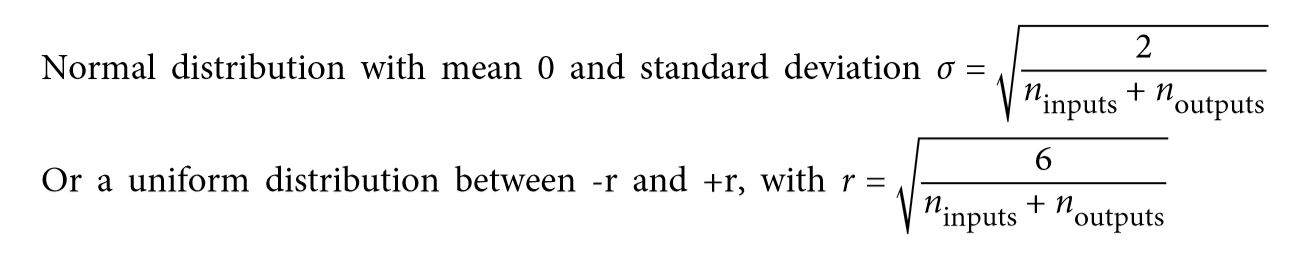

# Batch Normalization
In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called Batch Normalization (BN) to address the vanishing/exploding gradients problems, and more generally the problem that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change (which they call the Internal Covariate Shift problem). The technique consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, the other for shifting). In other words, this operation lets the model learn the optimal scale and mean of the inputs for each layer. In order to zero-center and normalize the inputs, the algorithm needs to estimate the inputs’ mean and standard deviation. It does so by evaluating the mean and standard deviation of the inputs over the current mini-batch (hence the name “Batch Normalization”). The whole operation is summarized in Equation 11-3. <br /> 
• μB is the empirical mean, evaluated over the whole mini-batch B.  <br /> 
• σB is the empirical standard deviation, also evaluated over the whole mini-batch.  <br /> 
• mB is the number of instances in the mini-batch. <br /> 
• x(i) is the zero-centered and normalized input.
• γ is the scaling parameter for the layer.<br /> 
• β is the shifting parameter (offset) for the layer.<br />
• ϵ is a tiny number to avoid division by zero (typically 10–3
This is called a smoothing term.<br />
• z(i) is the output of the BN operation: it is a scaled and shifted version of the inputs.Ref:1 chapter 11
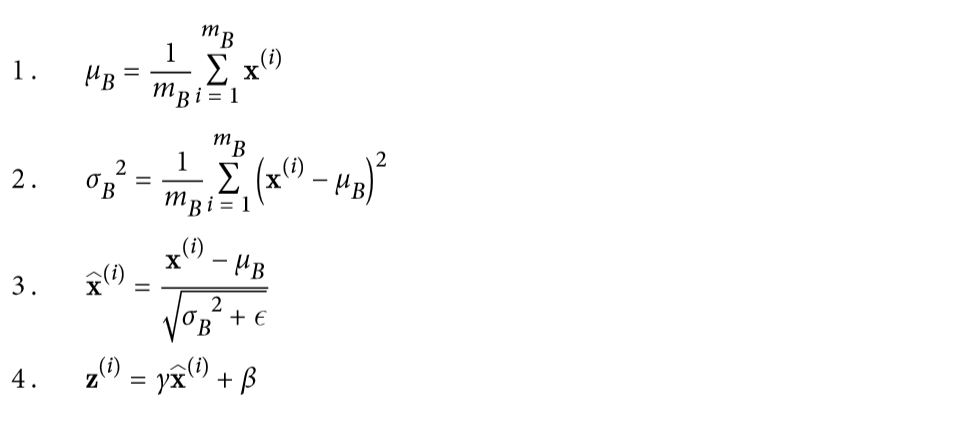

In [67]:
#Batch normalizaion function and He initializer
from functools import partial
batch_norm_momentum=0.95

he_init = tf.variance_scaling_initializer()

Custom_batch_normalized_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

Custum_dense_layer = partial(
            tf.layers.dense,kernel_initializer=he_init, use_bias=True, bias_initializer=tf.zeros_initializer(),
kernel_regularizer=max_norm_reg)

#  Activation Function (ELU)
“Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs),” D. Clevert, T. Unterthiner, S. Hochreiter (2015).
paper by Djork-Arné Clevert et al. proposed a new activation function called the exponential linear unit (ELU) that outperformed all the ReLU variants in their experiments: training time was reduced and the neural network performed better on the test set. It is represented in Figure, and Equation  shows its definition.
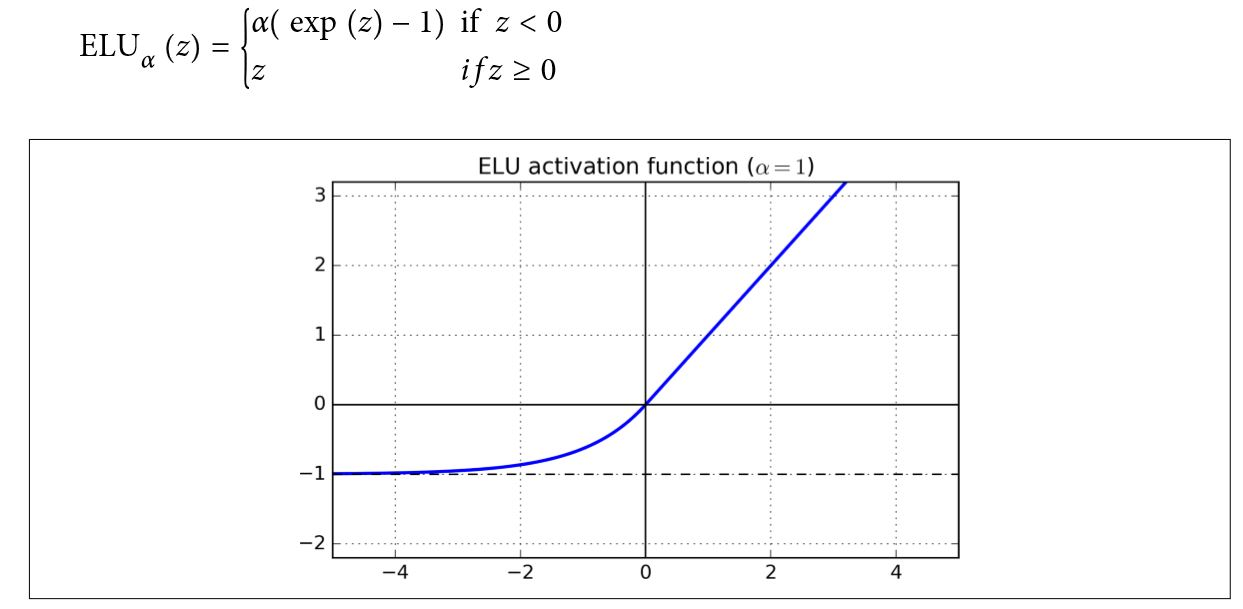

In [68]:


with tf.name_scope("dnn"):
    
    #layer1   
    hidden1 =Custum_dense_layer(X, n_hidden1,name="hidden1")
    bn1 = Custom_batch_normalized_layer(hidden1)
    hidden1_bn = tf.nn.relu(bn1)
    hidden1_drop = tf.layers.dropout(hidden1_bn, dropout_rate_1, training=training)

    #layer2   
    hidden2 =Custum_dense_layer(hidden1_drop, n_hidden2,name="hidden2")
    bn2 = Custom_batch_normalized_layer(hidden2)
    hidden2_bn = tf.nn.relu(bn2)
    hidden2_drop = tf.layers.dropout(hidden2_bn, dropout_rate_2, training=training)
    
    #layer3   
    hidden3 =Custum_dense_layer(hidden2_drop, n_hidden3,name="hidden3")
    bn3 = Custom_batch_normalized_layer(hidden3)
    hidden3_bn = tf.nn.relu(bn3)
    hidden3_drop = tf.layers.dropout(hidden3_bn, dropout_rate_3, training=training)
    
    #layer4
    hidden4 =Custum_dense_layer(hidden3_drop, n_hidden4,name="hidden4")
    bn4 = Custom_batch_normalized_layer(hidden4)
    hidden4_bn = tf.nn.relu(bn4)
    hidden4_drop = tf.layers.dropout(hidden4_bn, dropout_rate_4, training=training)
    #layer5
    hidden5 = Custum_dense_layer( hidden4_drop,n_hidden5,name="hidden5")
    bn5= Custom_batch_normalized_layer(hidden5)
    hidden5_n = tf.nn.elu(bn5)
    hidden5_drop= tf.layers.dropout(hidden5_n, dropout_rate_5, training=training)
    #layer6
    hidden6 = Custum_dense_layer( hidden5_drop,n_hidden6,name="hidden6")
    bn6= Custom_batch_normalized_layer(hidden6)
    hidden6_n = tf.nn.elu(hidden6)
    hidden6_drop= tf.layers.dropout(hidden6_n,dropout_rate_6, training=training)

    
    #output
    y_pred_before_BN = Custum_dense_layer(hidden6_drop,n_outputs,name="outputs")
    y_pred=Custom_batch_normalized_layer( y_pred_before_BN)







Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.


In [69]:
#Loss calculation and optimizer

mse = tf.losses.mean_squared_error(y,y_pred)




with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(mse,global_step=global_step)

init = tf.global_variables_initializer()

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [70]:
#batch making and shuffling
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# Gradient Clipping
A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold . This is called Gradient Clipping. In general people now prefer Batch Normalization, but it’s still useful. 

In [71]:
#Clipping gradient and saver object
saver = tf.train.Saver()
clip_all_weights=tf.get_collection("max_norm")

# Early Stopping
To avoid overfitting the training set, a great solution is early stopping: just interrupt training when its performance on the validation set starts dropping. One way to implement this with TensorFlow is to evaluate the model on a validation set at regular intervals (e.g., every 50 steps), and save a “winner” snapshot if it outperforms previous “winner” snapshots. Count the number of steps since the last “winner” snapshot was saved, and interrupt training when this number reaches some limit (e.g., 2,000 steps). Then restore the last “winner” snapshot.

In [73]:
#Session with Early stopping mechanism

max_checks_without_progress = 1500
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_val, y_train_val, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        loss_val = mse.eval(feed_dict={X: X_test_val, y: y_test_val})
        
        
        #Check whether to stop or not
        if loss_val < best_loss:
            save_path = saver.save(sess,"./Final_Certairi.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        
        #printing at run time
        if epoch %100==0:
            acc_batch = mse.eval(feed_dict={X: X_batch, y: y_batch})
            acc_val = mse.eval(feed_dict={X: X_test_val, y: y_test_val})
            

            
            
            print("Epoch_number",epoch, "Batch error:", acc_batch, "Val error:", acc_val)
    pred=y_pred.eval(feed_dict={X: x_test})

                
with tf.Session() as sess:
    saver.restore(sess, "./Final_Certairi.ckpt")
    pred_best=y_pred.eval(feed_dict={X: x_test})

KeyError: "None of [Int64Index([ 284,  645,  100,  127,   35,  506,  363,  473,  240,  995,  864,\n             899,  931,  923,  791,  796,  625,  456,  421,  552,  486,  116,\n             444, 1010,  944,   79,  661,  216,  683,  320,  684,   27,   98],\n           dtype='int64')] are in the [columns]"

In [267]:
pred_non_expo=np.expm1(pred)
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = pred_non_expo

sub.to_csv('Final With Early stopping.csv',index=False)

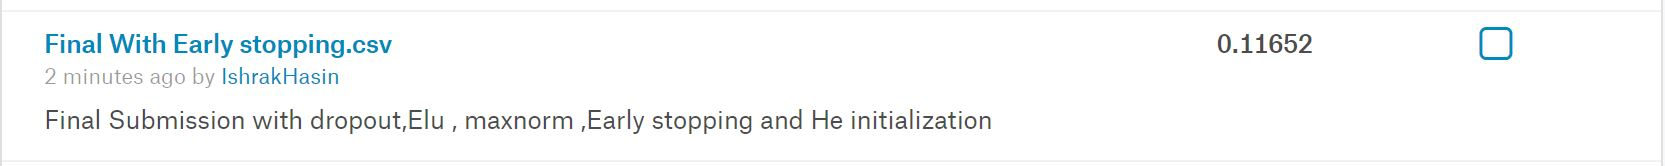

# Simple DNN for Prototyping

In [89]:
learning_rate = 0.1 
num_steps =10000
beta = .005
hidden_1 = 16 
hidden_2 = 8
hidden_3 = 4 
input_dim = x_train.shape[1]
output_dim = 1  
X_tf = tf.placeholder("float32" ) 
y_tf = tf.placeholder("float32" ) 

# Weights and Bias
Node: It is the basic unit of a neural network. It gets certain number of inputs and a bias value. When a signal(value) arrives, it gets multiplied by a weight value. If a neuron has 4 inputs, it has 4 weight values which can be adjusted during training time.<br /> 
Bias(ofset):It is an extra input to neurons and it is always 1, and has it’s own connection weight. This makes sure that even when all the inputs are none (all 0’s) there’s gonna be an activation in the neuron

In [90]:
weights = {'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),  
           'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),  
           'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])), 
           'out': tf.Variable(tf.random_normal([hidden_3, output_dim ])) }

biases = {'b1': tf.Variable(tf.random_normal([hidden_1])),
          'b2': tf.Variable(tf.random_normal([hidden_2])),
          'b3': tf.Variable(tf.random_normal([hidden_3])),
          'out': tf.Variable(tf.random_normal([output_dim])) } 

# Connections
It connects one neuron in one layer to another neuron in other layer or the same layer. A connection always has a weight value associated with it. Goal of the training is to update this weight value to decrease the loss(error).

# Activations
Activation functions are used to introduce non-linearity to neural networks. It squashes the values in a smaller range viz. a Sigmoid activation function squashes values between a range 0 to 1. There are many activation functions used in deep learning industry and ReLU, SeLU and TanH are preferred over sigmoid activation function.

In [91]:
 def ann_model(X_val): 
        layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1' ]) 
        layer_1 = tf.nn.relu(layer_1) 
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2) 
        layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']) 
        layer_3 = tf.nn.relu(layer_3)
        layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases ['out']) 
        return layer_out 

# Loss Function/Cost Function 
The loss function computes the error for a single training example. The cost function is the average of the loss functions of the entire training set.<br /> 
<br /> 
1.‘mse’: for mean squared error.<br /> 
2.‘binary_crossentropy’: for binary logarithmic loss (logloss).<br /> 
3.‘categorical_crossentropy’: for multi-class logarithmic loss (logloss).<br /> 
Here we used MSE

In [92]:
# Model Construct 
model = ann_model(X_tf) 
# Mean Squared Error cost function
cost = tf.reduce_mean(tf.square(y_tf - model)) 


# Regularization
It is used to overcome the over-fitting problem. In regularization we penalise our loss term by adding a L1 (LASSO) or an L2(Ridge) norm on the weight vector w (it is the vector of the learned parameters in the given algorithm).
L(Loss function) + λN(w) — here λ is your regularization term and N(w) is L1 or L2 norm. Here L2 is used.


In [93]:
regularizer_1 = tf.nn.l2_loss(weights['w1']) 
regularizer_2 = tf.nn.l2_loss(weights['w2']) 
regularizer_3 = tf.nn.l2_loss(weights['w3']) 
cost = tf.reduce_mean(cost + beta*regularizer_1 + beta*regularizer_2 
                      + regularizer_3)

# Model Optimizers
The optimizer is a search technique, which is used to update weights in the model.<br /> 

SGD: Stochastic Gradient Descent, with support for momentum.<br /> 

RMSprop: Adaptive learning rate optimization method proposed by Geoff Hinton.<br /> 

Adam: Adaptive Moment Estimation (Adam) that also uses adaptive learning rates<br /> 
Here we used Adam.

In [94]:
# Adam optimizer will update weights and biases after each step 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) .minimize(cost)

In [95]:
# Initialize variables 
init = tf.global_variables_initializer() 

In [96]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver() 

# Graph and Session
TensorFlow uses a dataflow graph to represent your computation in terms of the dependencies between individual operations. This leads to a low-level programming model in which you first define the dataflow graph, then create a TensorFlow session to run parts of the graph across a set of local and remote devices.


In [97]:
max_checks_without_progress = 1500
checks_without_progress = 0
best_loss = np.infty
loss_val_list=[]
loss_actual_list=[]
epoch_list=[]
with tf.Session() as sess: 
        sess.run(init) 
        for i in range(num_steps): 
            sess.run(optimizer, feed_dict={X_tf:X_train_val, y_tf:y_train_val})  
            if (i+1)%100 == 0: 
                loss_val = cost.eval(feed_dict={X_tf: X_test_val, y_tf: y_test_val})
                loss_acc = cost.eval(feed_dict={X_tf:X_train_val, y_tf:y_train_val}) 

                print("epoch no : ",i+1,"Loss",loss_val) 
                loss_val_list.append(loss_val)
                epoch_list.append(i)
                loss_actual_list.append(loss_acc)
                           #Check whether to stop or not
                if loss_val < best_loss:
                    save_path = saver.save(sess,"./Final_Certairi2.ckpt")
                    best_loss = loss_val
                    checks_without_progress = 0
                else:
                    checks_without_progress += 1
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
        save_path = saver.save(sess, "/tmp/final2.ckpt") 
        print("Model saved in path: %s" % save_path) 
        pred_model = sess.run(model, feed_dict={X_tf:x_test}) 
with tf.Session() as sess:
    saver.restore(sess, "./Final_Certairi2.ckpt")
    pred_best = sess.run(model, feed_dict={X_tf:x_test}) 

epoch no :  100 Loss 7.536833
epoch no :  200 Loss 3.5494757
epoch no :  300 Loss 1.9466459
epoch no :  400 Loss 1.2247047
epoch no :  500 Loss 0.8550304
epoch no :  600 Loss 0.6488242
epoch no :  700 Loss 0.52300537
epoch no :  800 Loss 0.5684882
epoch no :  900 Loss 0.37239116
epoch no :  1000 Loss 0.32463315
epoch no :  1100 Loss 0.28692675
epoch no :  1200 Loss 0.25600734
epoch no :  1300 Loss 0.23171273
epoch no :  1400 Loss 0.21158911
epoch no :  1500 Loss 0.19465831
epoch no :  1600 Loss 0.1802741
epoch no :  1700 Loss 0.16799355
epoch no :  1800 Loss 0.15752637
epoch no :  1900 Loss 0.14872168
epoch no :  2000 Loss 0.1415634
epoch no :  2100 Loss 0.13611954
epoch no :  2200 Loss 0.13233837
epoch no :  2300 Loss 0.12985612
epoch no :  2400 Loss 0.12817454
epoch no :  2500 Loss 0.12697318
epoch no :  2600 Loss 0.12608089
epoch no :  2700 Loss 0.12541425
epoch no :  2800 Loss 0.124896996
epoch no :  2900 Loss 0.12450331
epoch no :  3000 Loss 0.12419283
epoch no :  3100 Loss 0.1239

# learning Curve

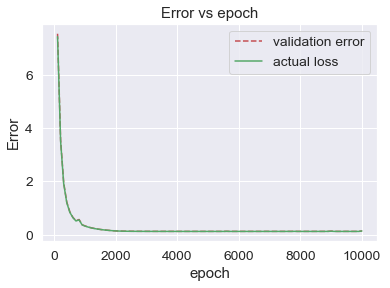

In [103]:
plt.plot(epoch_list,loss_val_list,'r--',label='validation error')
plt.plot(epoch_list,loss_actual_list,'g',label='actual loss')

plt.legend()
plt.ylabel('Error')
plt.xlabel('epoch')
plt.title('Error vs epoch')
plt.show()

In [75]:
prediction = np.expm1(pred_best) 


In [77]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = prediction

sub.to_csv('Super.csv',index=False)

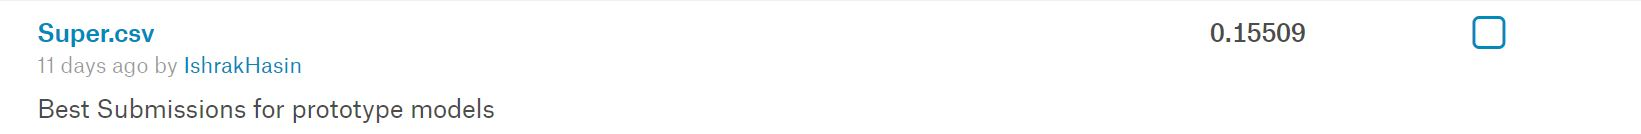

Note: The Final model is the model above the current model. The last model is the simplified model for quick prototyping. 

# Discussion


This above(Final Nodel) mentioned model is highly flexible and can be tuned according to the necessity.We can have a exhustive search on top of that.For the final model I used Max norm normalization and dropout as regularizer.Kernel is regularized with batch normalization and initialized by he initialization.Dropout rates can be tuned per layer.As activation fuction I used elu instead of relu. This model checks for improvement in validation set for 2000 step if no improvement is found the model stops the training.Since the model is so flexible the next step, will be to search over the entire parameter spaces using oscar,randomsearchCV or Grid Search.Lastly, This is pretty strong model and made without any prior on data preprocessing so better result can be achived with strong data preprocessing knowledge.

# Reference

Any suggestion is greatly welcomed.<br />
Mail Id for comment:hasinishrak12@gmail.com

# GRID Search for best params

In [63]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [66]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [67]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [68]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

NameError: name 'X_train' is not defined